# Link Prediction using VGAE


The objective of this notebook is to do link prediction using different architectures of `VGAE`.

A link prediction is to make predictions on edges using node embeddings. As we will be using Variational Graph Auto-Encoders we will process the problem as follow:

1. An encoder creates node embeddings by processing the graph with convolutions
layers.
2. We randomly add negative links to the original graph. Which makes the model task a binary classification with the positive links from the original edges and the negative links from the added edges.
3. A decoder makes link predictions (binary classifications) on all the edges including the negative links using node embeddings. It calculates a dot product of the node embeddings from a pair of nodes on each edge. Then, it aggregates the values across the embedding dimension and creates a single value on every edge that represents the probability of edge existence.


L’ets stars by downloading necessary packages

In [4]:
%pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
%pip install torch_geometric

Looking in links: https://data.pyg.org/whl/torch-2.4.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.0/541.0 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 787.5/787.5 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.3 MB/s eta 0:00:00


## Experiment

Importing packages

In [5]:
import networkx as nx
import numpy as np
import torch
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, VGAE
from torch_geometric.utils import from_networkx, negative_sampling, to_networkx
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
import torch.nn as nn
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import random

We will make sure that the experiments are reproducible with the seed

In [6]:
def make_deterministic(random_seed = 42):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

make_deterministic()

Reading our graph and visualisation

In [7]:
import networkx as nx
from torch_geometric.utils import from_networkx

# reading our graph
G = nx.read_graphml("airportsAndCoordAndPop.graphml")

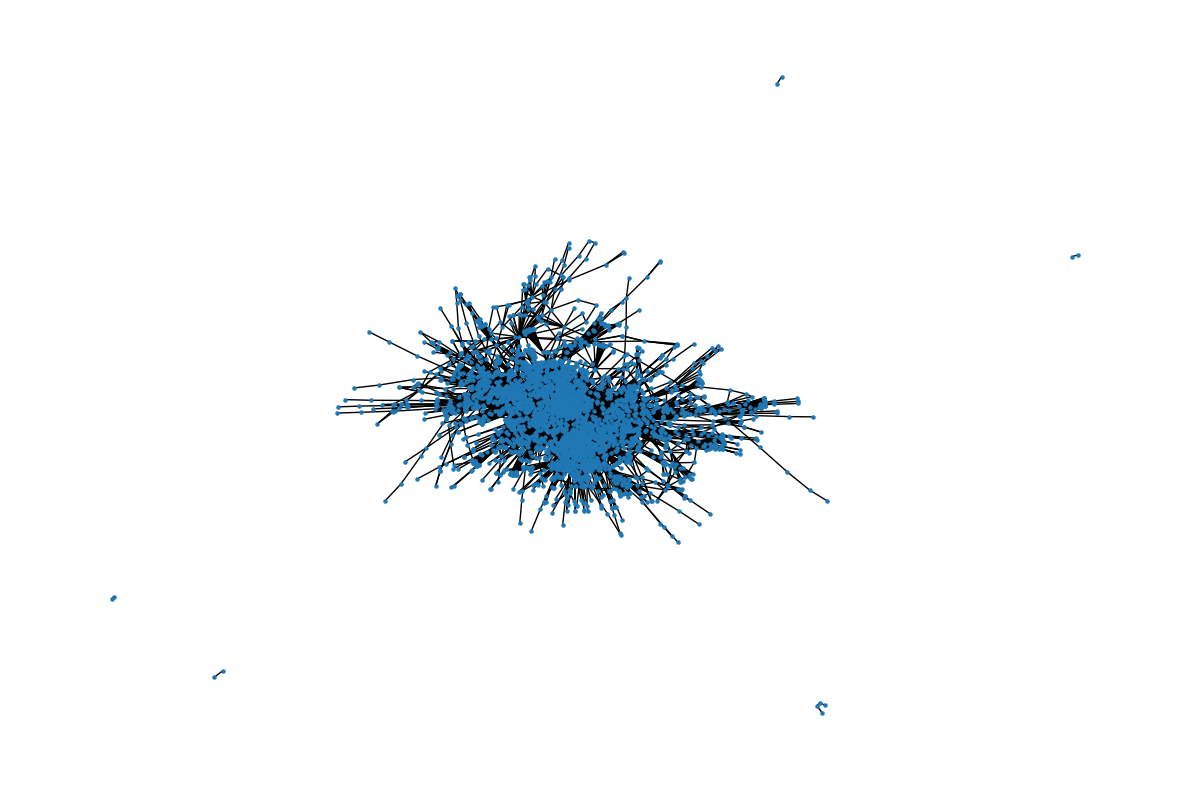

In [8]:
import matplotlib.pyplot as plt

# plotting the graph
plt.figure(figsize=(12, 8))
nx.draw_networkx(G, with_labels=False, node_size=5)
plt.axis('off')
plt.tight_layout()
plt.show()

We will use the 5 attributes city_name, country, population, lat and log to form our features vector for each node

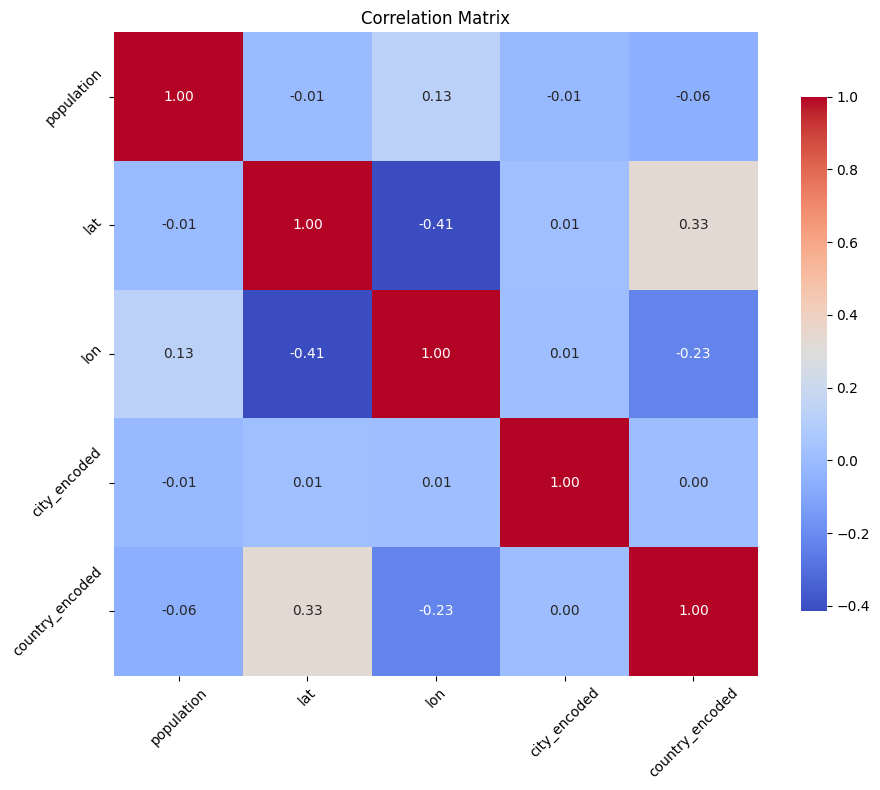

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix():
    # Convert NetworkX graph to PyTorch Geometric data
    data = from_networkx(G)

    # Extract node features
    node_features = []
    for node, attrs in G.nodes(data=True):
        node_features.append([
            attrs['city_name'],
            attrs['country'],
            attrs['population'],
            attrs['lat'],
            attrs['lon']
        ])

    # Convert to DataFrame for easy processing
    df = pd.DataFrame(node_features, columns=['city_name', 'country', 'population', 'lat', 'lon'])

    # Encode categorical variables
    le_city = LabelEncoder()
    le_country = LabelEncoder()
    df['city_encoded'] = le_city.fit_transform(df['city_name'])
    df['country_encoded'] = le_country.fit_transform(df['country'])

    # Normalize numeric features
    scaler = StandardScaler()
    numeric_features = ['population', 'lat', 'lon', 'city_encoded', 'country_encoded']
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

    # Compute the correlation matrix
    correlation_matrix = df[numeric_features].corr()

    # Plotting the correlation matrix using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_correlation_matrix()

Based on the correlation matrix shown in the image, we decided to take the 5 elements as our features vector for each node.

In [40]:
import torch_geometric.transforms as T

def prepare_data(G):
    # Convert NetworkX graph to PyTorch Geometric data
    data = from_networkx(G)

    # Extract node features
    node_features = []
    for node, attrs in G.nodes(data=True):
        node_features.append([
            attrs['city_name'],
            attrs['country'],
            attrs['population'],
            attrs['lat'],
            attrs['lon']
        ])

    # Convert to DataFrame for easy processing
    df = pd.DataFrame(node_features, columns=['city_name', 'country', 'population', 'lat', 'lon'])

    # Encode categorical variables
    le_city = LabelEncoder()
    le_country = LabelEncoder()
    df['city_encoded'] = le_city.fit_transform(df['city_name'])
    df['country_encoded'] = le_country.fit_transform(df['country'])

    # Normalize numeric features
    scaler = StandardScaler()
    numeric_features = ['population', 'lat', 'lon', 'city_encoded', 'country_encoded']
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

    # Create feature matrix
    x = torch.tensor(df[numeric_features].values, dtype=torch.float)
    data.x = x

    return data


In [41]:
data = prepare_data(G)
print(f"Number of nodes: {data.x.shape[0]}")
print(f"Number of node features: {data.x.shape[1]}")
print(f"Number of edges: {data.edge_index.shape[1]}")

Number of nodes: 3363
Number of node features: 5
Number of edges: 27094


Our data now should contain 5 features on each node and in our edges which represent the connexions between two nodes

In [11]:
data.x

tensor([[-0.2599, -1.3766, -1.5157, -1.6277, -0.6522],
        [-0.2599, -1.4009, -1.4684, -0.6041, -0.6522],
        [-0.2470, -1.3833, -1.5581,  0.5921, -0.6522],
        ...,
        [-0.2599,  1.0815, -1.1808,  1.6367, -1.1196],
        [-0.2599, -0.9941,  1.5126,  1.6767,  0.4385],
        [-0.2599, -0.9895,  1.5193,  1.5967,  0.4385]])

In [12]:
data.edge_index.T

tensor([[   0,    1],
        [   0,    2],
        [   1,    0],
        ...,
        [3361, 3359],
        [3361, 3362],
        [3362, 3361]])

Let's now define our two architectures which are both a VGAE architectures the difference is that we will use for one GCN and for the other the GAT for convolutions

In [13]:
class VGAE_GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, output_channels):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, output_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [14]:
class VGAE_GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, output_channels):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=8)
        self.conv2 = GATConv(hidden_channels * 8, output_channels, heads=1, concat=False)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [26]:
from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.utils import negative_sampling

def train_link_predictor(model, train_data, val_data, optimizer, criterion, n_epochs=100):

    for epoch in range(1, n_epochs + 1):

        model.train()
        optimizer.zero_grad()
        z = model.encode(train_data.x, train_data.edge_index)

        # sampling training negatives for every training epoch
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        val_auc, val_ap = eval_link_predictor(model, val_data)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}, Val Average Precision: {val_ap:.3f}")


    return model, val_auc, val_ap

In [27]:
@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    ap = average_precision_score(data.edge_label.cpu().numpy(), out.cpu().numpy())
    auc = roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

    return auc, ap

## Results

We train our architectures on different hyperparameters and finally, we take the best of them from the training phase then we compare them in the test phase

In [31]:
# Define model candidates
models = {
    'VGAE_GCN': VGAE_GCN,
    'VGAE_GAT': VGAE_GAT,
}

final_models = []

num_features = data.x.size(1)

# criterion
criterion = nn.BCEWithLogitsLoss()

# Hyperparams
lrs = [1e-2, 1e-3, 1e-4]
hidden_channels = [128, 64]

models_gcn = []
models_gat = []

split = T.RandomLinkSplit(
num_val=0.05,
num_test=0.1,
is_undirected=True,
add_negative_train_samples=False,
neg_sampling_ratio=1.0,
)
train_data, val_data, _ = split(data)

for model_name, ModelClass in models.items():
  for lr in lrs:
    for hidden_channel in hidden_channels:
      # Define model
      model = ModelClass(num_features, hidden_channel, 64)
      optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
      print(f"\nModel {model_name}: lr={lr} idden_channel={hidden_channel}")
      model, val_auc, val_ap = train_link_predictor(model, train_data, val_data, optimizer, criterion)
      if model_name == 'VGAE_GCN':
        models_gcn.append((model, lr, hidden_channel, val_auc, val_ap))
      else:
        models_gat.append((model, lr, hidden_channel, val_auc, val_ap))


Model VGAE_GCN: lr=0.01 idden_channel=128
Epoch: 10, Train Loss: 0.476, Val AUC: 0.926, Val Average Precision: 0.929
Epoch: 20, Train Loss: 0.451, Val AUC: 0.942, Val Average Precision: 0.948
Epoch: 30, Train Loss: 0.437, Val AUC: 0.944, Val Average Precision: 0.952
Epoch: 40, Train Loss: 0.427, Val AUC: 0.948, Val Average Precision: 0.957
Epoch: 50, Train Loss: 0.427, Val AUC: 0.947, Val Average Precision: 0.956
Epoch: 60, Train Loss: 0.421, Val AUC: 0.952, Val Average Precision: 0.961
Epoch: 70, Train Loss: 0.419, Val AUC: 0.953, Val Average Precision: 0.961
Epoch: 80, Train Loss: 0.413, Val AUC: 0.955, Val Average Precision: 0.964
Epoch: 90, Train Loss: 0.412, Val AUC: 0.960, Val Average Precision: 0.967
Epoch: 100, Train Loss: 0.408, Val AUC: 0.956, Val Average Precision: 0.965

Model VGAE_GCN: lr=0.01 idden_channel=64
Epoch: 10, Train Loss: 0.493, Val AUC: 0.919, Val Average Precision: 0.922
Epoch: 20, Train Loss: 0.470, Val AUC: 0.929, Val Average Precision: 0.934
Epoch: 30, Tra

In [32]:
i = 0
test_sizes = [0.1, 0.2]

print(max(models_gat, key=lambda x: (x[3], x[4])))
best_gat_model = max(models_gat, key=lambda x: (x[3], x[4]))[0]

print(max(models_gcn, key=lambda x: (x[3], x[4])))
best_gcn_model = max(models_gcn, key=lambda x: (x[3], x[4]))[0]

for ts in test_sizes:
  split = T.RandomLinkSplit(
  num_val=0.05,
  num_test=ts,
  is_undirected=True,
  add_negative_train_samples=False,
  neg_sampling_ratio=1.0,
  )
  _, _, test_data = split(data)

  test_auc, test_ap = eval_link_predictor(best_gcn_model, test_data)
  print(f"Best VGAE_GCN on test_size={ts}: Test AUC: {test_auc:.3f} Test AP: {test_ap:.3f}")

  test_auc, test_ap = eval_link_predictor(best_gat_model, test_data)
  print(f"Best VGAE_GAT on test_size={ts} : Test AUC: {test_auc:.3f} Test AP: {test_ap:.3f}")

(VGAE_GAT(
  (conv1): GATConv(5, 64, heads=8)
  (conv2): GATConv(512, 64, heads=1)
), 0.01, 64, 0.9227890881877429, 0.9192083467685866)
(VGAE_GCN(
  (conv1): GCNConv(5, 128)
  (conv2): GCNConv(128, 64)
), 0.01, 128, 0.9559704928119321, 0.9650333801833104)
Best VGAE_GCN on test_size=0.1: Test AUC: 0.970 Test AP: 0.974
Best VGAE_GAT on test_size=0.1 : Test AUC: 0.933 Test AP: 0.923
Best VGAE_GCN on test_size=0.2: Test AUC: 0.971 Test AP: 0.973
Best VGAE_GAT on test_size=0.2 : Test AUC: 0.942 Test AP: 0.938
